In [2]:
# Import PySpark
import pyspark
from pyspark.sql import SparkSession

#Create SparkSession
spark = SparkSession.builder.master("local[2]").appName("test1").getOrCreate()

23/08/03 16:01:05 WARN Utils: Your hostname, SHEETAL-PC resolves to a loopback address: 127.0.1.1; using 192.168.2.102 instead (on interface wlp1s0)
23/08/03 16:01:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/08/03 16:01:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from functools import reduce
from pyspark.sql import DataFrame

import pyspark.sql.functions as F

from pyspark.sql.functions import when

from pyspark.sql.functions import rand
from pyspark.sql.functions import lit

In [4]:
df = spark.read.csv(path=r'/media/sheetal_ubuntu/OS/Users/sheet/Dataset/data_Q2_2022/data_Q2_2022/*',header= True ,inferSchema = True)
df.show(5)

23/08/03 16:03:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+-------------------+-------------+--------------------+--------------+-------+------------------+-----------+------------------+-----------+------------------+-----------+------------------+-----------+------------------+-----------+------------------+-----------+------------------+-----------+------------------+-----------+-------------------+------------+-------------------+------------+-------------------+------------+-------------------+------------+-------------------+------------+-------------------+------------+-------------------+------------+-------------------+------------+-------------------+------------+-------------------+------------+-------------------+------------+--------------------+-------------+--------------------+-------------+--------------------+-------------+--------------------+----

In [5]:
#Business Understanding

In [6]:
#Create a Dummy field to use in aggregations.
df = df.withColumn("dummy", lit(1))

#aggregate the data
total = df.groupBy('dummy').agg(F.mean("failure").alias('avg_failure')).collect()
#convert output to rdd
rdd = spark.sparkContext.parallelize(total)
#convert output to spark
zz=rdd.toDF()
#rename the column
zz=zz.withColumnRenamed("avg_failure","GLOBAL_AVG_FAILURE")
#multiply by 10,000, for formatting purposes.
zz = zz.withColumn("GLOBAL_AVG_FAILURE", zz.GLOBAL_AVG_FAILURE*10000)
zz.show(200)

+-----+------------------+
|dummy|GLOBAL_AVG_FAILURE|
+-----+------------------+
|    1|0.3799235012855941|
+-----+------------------+



In [7]:
#Join the global average to the original data frame
df=df.join(zz,(df.dummy) ==  (zz.dummy),"inner")

### Aggregate the failure rate by Model.

1.F.mean("failure").alias('avg_failure'): The mean function calculates the average value of the 'failure' column for each 'model'. In other words, it adds up all the 'failure' values and divides by the number of rows for each 'model'. The alias function is used to rename the resulting column as 'avg_failure'.

2.F.count("failure").alias('count_failure'): The count function counts the number of rows for each 'model'. So, for each 'model', it gives the number of times 'failure' has a value (including zero). The resulting column is renamed to 'count_failure' using alias.

3.F.sum("failure").alias('sum_failure'): The sum function adds up all the 'failure' values for each 'model'. So, for each 'model', it will give the total 'failure' value. The resulting column is renamed to 'sum_failure' using alias.

4.F.mean("GLOBAL_AVG_FAILURE").alias('GLOBAL_AVG_FAILURE'): This is calculating the average value of the 'GLOBAL_AVG_FAILURE' column for each 'model', similar to how the average of 'failure' was calculated. The resulting column retains the same name 'GLOBAL_AVG_FAILURE'.


..................................................................................................................





Threshold for determining when to replace the model's failure rate with the global average failure rate is 10000. 

for models with fewer than 10,000 failures, the model-specific failure rate is not reliable or robust enough, and thus it should be replaced with the global average failure rate.

In [33]:
#Calculate the summaries.
total = df.groupBy('model').agg(F.mean("failure").alias('avg_failure'),F.count("failure").alias('count_failure'),\
                                       F.sum("failure").alias('sum_failure'),F.mean("GLOBAL_AVG_FAILURE").alias('GLOBAL_AVG_FAILURE')).collect()
#Convert to RDD
rdd = spark.sparkContext.parallelize(total)
#convert output to spark

zz=rdd.toDF()
#rename columns
zz=zz.withColumnRenamed("avg_failure","MODEL_FAIL_RATE")
zz=zz.withColumnRenamed("sum_failure","MODEL_FAIL_TOTAL")
zz=zz.withColumnRenamed("count_failure","INSTANCE_COUNT_PER_MODEL")
#multiply by 10,000 to make them easier to read and deal with
zz = zz.withColumn("MODEL_FAIL_RATE", zz.MODEL_FAIL_RATE*10000)

#replace values when total for a summary is less than 10,000
df_model = zz.withColumn("MODEL_FAIL_RATE", when(zz.INSTANCE_COUNT_PER_MODEL<10000,zz.GLOBAL_AVG_FAILURE).otherwise(zz.MODEL_FAIL_RATE))



zz.show(200)

+--------------------+--------------------+------------------------+----------------+-------------------+
|               model|     MODEL_FAIL_RATE|INSTANCE_COUNT_PER_MODEL|MODEL_FAIL_TOTAL| GLOBAL_AVG_FAILURE|
+--------------------+--------------------+------------------------+----------------+-------------------+
|       ST16000NM005G|                 0.0|                    4706|               0| 0.3799235012855952|
|         ST4000DM000|  0.8145514089352411|                 3351538|             273|0.37992350128568486|
|WDC  WUH721414ALE6L4|                 0.0|                   25025|               0|0.37992350128559454|
|       ST12000NM0007|   1.481193079865931|                  236296|              35| 0.3799235012855892|
|         ST8000DM005|                 0.0|                    4537|               0| 0.3799235012855935|
| TOSHIBA MQ01ABF050M|  3.8582479695970058|                   51837|              20| 0.3799235012855927|
|        ST8000NM0055|  0.6350264421161852|   

In [ ]:
df4=df2.select(countDistinct("serial_number"))
df4.show()

In [ ]:
from pyspark.sql.functions import countDistinct
df3=df2.select(countDistinct("model"))
df3.show()

In [34]:
#convert to Pandas
df_model_pd = df_model.toPandas()
df_model_pd.head()

,model,MODEL_FAIL_RATE,INSTANCE_COUNT_PER_MODEL,MODEL_FAIL_TOTAL,GLOBAL_AVG_FAILURE
0,ST16000NM005G,0.379924,4706,0,0.379924
1,ST4000DM000,0.814551,3351538,273,0.379924
2,WDC WUH721414ALE6L4,0.000000,25025,0,0.379924
3,ST12000NM0007,1.481193,236296,35,0.379924
4,ST8000DM005,0.379924,4537,0,0.379924


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


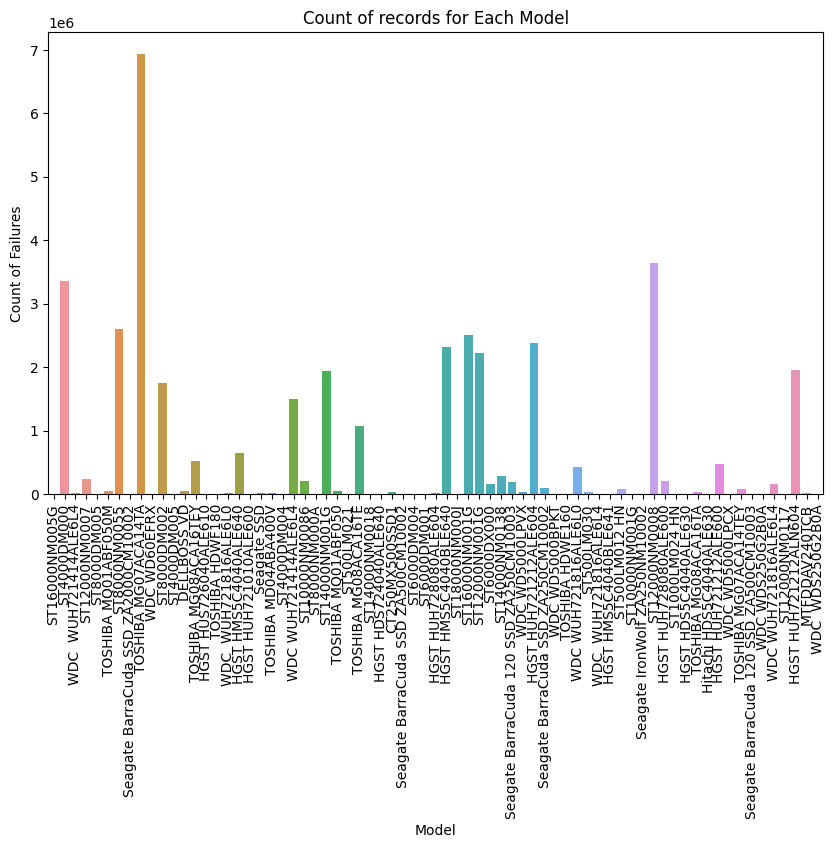

In [36]:
plt.figure(figsize=(10,6))
sns.barplot(x='model', y='INSTANCE_COUNT_PER_MODEL', data=df_model_pd)
plt.title('Count of records for Each Model')
plt.xlabel('Model')
plt.ylabel('Instance count per model')
plt.xticks(rotation=90)
plt.show()


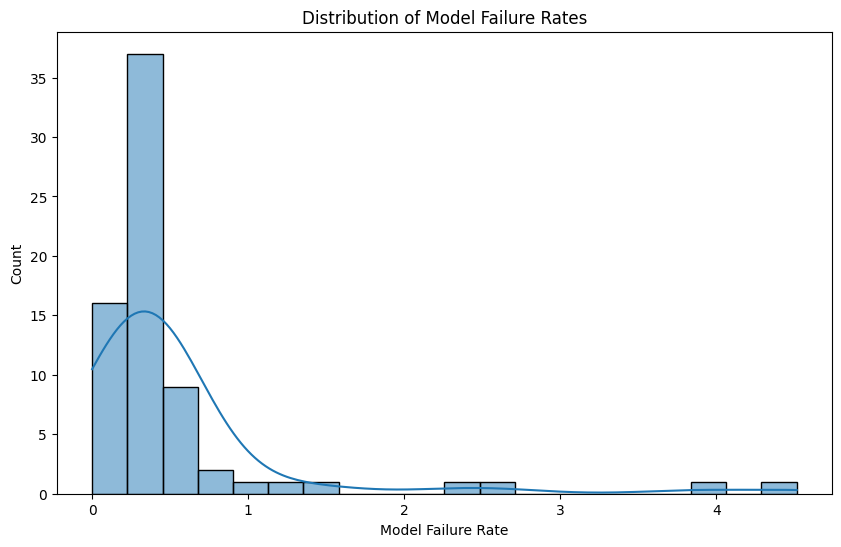

In [37]:
plt.figure(figsize=(10,6))
sns.histplot(df_model_pd['MODEL_FAIL_RATE'], bins=20, kde=True)
plt.title('Distribution of Model Failure Rates')
plt.xlabel('Model Failure Rate')
plt.show()


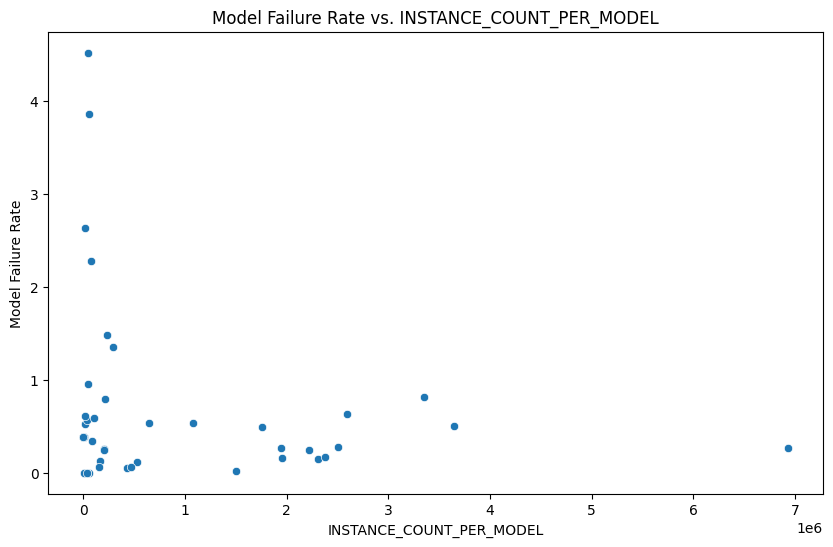

In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='INSTANCE_COUNT_PER_MODEL', y='MODEL_FAIL_RATE', data=df_model_pd)
plt.title('Model Failure Rate vs. INSTANCE_COUNT_PER_MODEL')
plt.xlabel('INSTANCE_COUNT_PER_MODEL')
plt.ylabel('Model Failure Rate')
plt.show()
